In [28]:
import sys
sys.path.append('..')

import os
import torch
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt
import IPython.display as ipd

from src.model import VaeModel
from src.dataset import NsynthDataset
from src.utils import Bunch, SpecDenormalize


In [2]:
%load_ext autoreload
%autoreload 2

# Load VAE model

In [5]:
cfg = Bunch({
    # general
    'seed': 42,
    # data
    'sr': 16000,
    'duration': 4,
    'batch_size': 32,
    'num_workers': 4,
    'n_mels': 80,
    'data_mean': -41.5759,  # in db
    'data_std': 38.5646,  # in db
    # training
    'start_lr': 1e-4,
    'epochs': 100,
    'val_every': 10,
    'loss_type': 'classes',
    # model
    'fc_hidden1': 512,
    'fc_hidden2': 1024,
    'fc_hidden3': 896,
    'lspace_size': 256,
    # loss
    'rec_weight': 1.0,
    'kld_weight': 0.01,
    'ce_weight': 0.1,
    'kld_exp': 0.5,
})

model = VaeModel(None, cfg.fc_hidden1, cfg.fc_hidden2, cfg.fc_hidden3, cfg.lspace_size)
state_dict = torch.load('../checkpoints/epoch_0100.pth', map_location='cuda')
model.load_state_dict(state_dict['model_state_dict'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['loss.fc_classes.weight', 'loss.fc_classes.bias'])

# Generate random samples

In [10]:
def plot_reconstructions(x_reconst, sr=16000):
    batch_size = x_reconst.shape[0]
    nrows = 4
    ncols = batch_size // nrows
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, 8))
    for i, (ax, x) in enumerate(zip(axs.flatten(), x_reconst)):
        xx = x.squeeze(0).detach().cpu().numpy()
        lrd.specshow(xx, ax=ax, cmap='magma')
        ax.set_title(f'{i}')
    fig.tight_layout()
    plt.show()


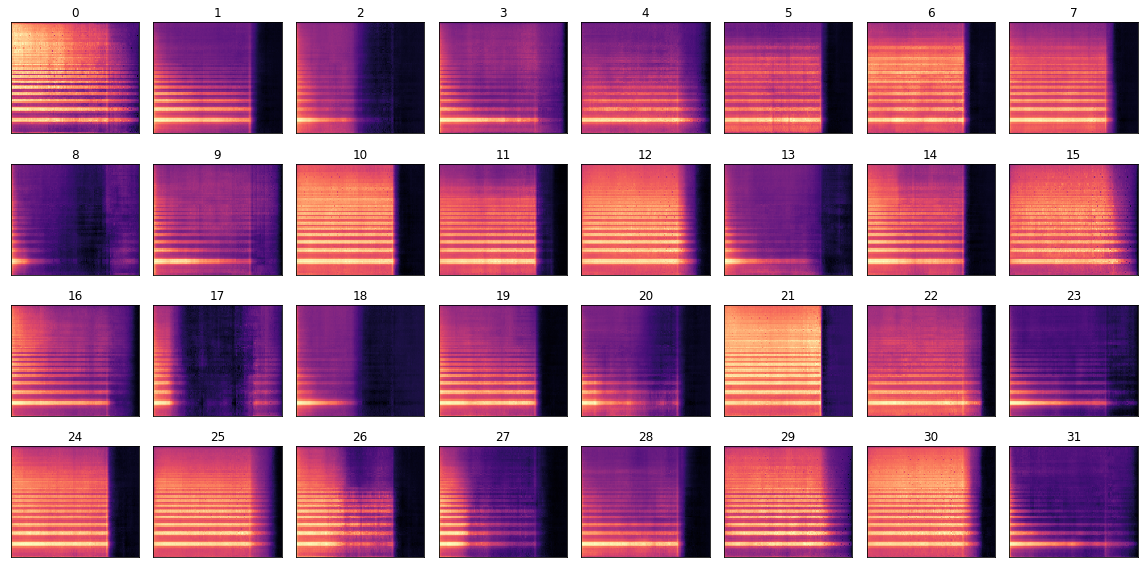

In [29]:
data_mean = torch.load('../data_mean.pt')
data_std = torch.load('../data_std.pt')
denorm = SpecDenormalize(data_mean=data_mean, data_std=data_std)
z = torch.randn(cfg.batch_size, cfg.lspace_size)
x_new = model.decode(z)
x_new = denorm(x_new)
x_new = x_new.squeeze(1).to('cuda')

plot_reconstructions(x_new)

# Convert using griffin-lim

In [30]:
def mel2wav_griffinlim(x):
  return lr.feature.inverse.mel_to_audio(x.detach().cpu().numpy(), sr=16000, n_fft=1024, win_length=1024, hop_length=256)

In [31]:
audios2 = [mel2wav_griffinlim(x_new_i) for x_new_i in x_new[:8]]
for audio in audios2:
  ipd.display(ipd.Audio(audio, rate=16000))